**Chapter 1** RNA-Seq Data Processing and Analysis: Alignment, Quality Control, and Quantification

**Section 1-4** Compare RSEM vs Salmon

Adapted from *STAT 115 2021 Homework 1 Problem 6*

---

We have completed RNA-Seq quantification using two different algorithms: `RSEM` and `Salmon`. In the previous section, we compared their computation speeds, where Salmon (**3** seconds) was significantly faster than RSEM (**32** seconds).

In this section, we compare the differences in quantification results between the two methods. Our analysis focuses on the following key metrics: **effective length**, **normalized read counts**, **TPM**, and **FPKM**, to evaluate the differences in their quantification outputs.

## 1 Data Preprocessing

We now focus on the following key metrics in RSEM and Salmon: **Effective Length**, **Normalized Read Count**, **TPM**, and **FPKM**.

First, we copy the RSEM result file `RSEMOut.isoforms.results` and the Salmon result file `quant.sf`, then open them using Python.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
rsemout = pd.read_csv('RSEMOut.isoforms.results', sep="\t")
rsemout.head(6)

,transcript_id,gene_id,length,effective_length,expected_count,TPM,FPKM,IsoPct
0,ETS1-1_rRNA,ETS1-1,700,462.14,47.0,92.85,186.60,100.0
1,ETS1-2_rRNA,ETS1-2,700,462.14,47.0,92.85,186.60,100.0
2,ETS2-1_rRNA,ETS2-1,211,7.08,0.5,64.45,129.52,100.0
3,ETS2-2_rRNA,ETS2-2,211,7.08,0.5,64.45,129.52,100.0
4,HRA1_ncRNA,HRA1,564,326.18,2.0,5.60,11.25,100.0
5,ICR1_ncRNA,ICR1,3199,2961.13,16.0,4.93,9.91,100.0


In [3]:
salmonout = pd.read_csv('quant.sf', sep="\t")
salmonout.head(6)

,Name,Length,EffectiveLength,TPM,NumReads
0,YDL248W_mRNA,1152,914.153,67.919553,107.958
1,YDL247W-A_mRNA,75,75.000,0.000000,0.000
2,YDL247W_mRNA,1830,1592.153,1.397396,3.869
3,YDL246C_mRNA,1074,836.153,12.380668,18.000
4,YDL245C_mRNA,1704,1466.153,0.196132,0.500
5,YDL244W_mRNA,1023,785.153,8.472899,11.567


In RSEM and Salmon, the read count metrics are `expected_count` and `NumReads`, respectively.

We analyze the *sum*, *average*, and *standard deviation* of these metrics to understand the data distribution, which helps in evaluating normalization methods.

In [5]:
rsemout_summary = pd.DataFrame({
    "total_sum": [rsemout["expected_count"].sum(skipna=True)],
    "average": [rsemout["expected_count"].mean(skipna=True)],
    "std": [rsemout["expected_count"].std(skipna=True)]
})

salmonout_summary = pd.DataFrame({
    "total_sum": [salmonout["NumReads"].sum(skipna=True)],
    "average": [salmonout["NumReads"].mean(skipna=True)],
    "std": [salmonout["NumReads"].std(skipna=True)]
})

display(rsemout_summary, salmonout_summary)

,total_sum,average,std
0,545040.96,76.47551,249.244359


,total_sum,average,std
0,669927.005,97.899606,305.289764


The key metrics: **Effective Length**, **Normalized Read Count**, **TPM**, and **FPKM**.

Among them, `Effective Length` and `TPM` are already provided in the original datasets, but we need to process **Normalized Read Count** and **FPKM** for comparison.

**1.Normalized Read Count**

Normalized Read Count is calculated as:
$$ \text{Normalized Read Count} =\frac{\text{Read Count}}{sum\text{(Read Count)}} \times i$$
where `i` is the normalization factor. Since the total read count is in the order of Million, we use 1,000,000 as the factor. This metric is named **ReadsPerMil**.

**2.FPKM**

In RSEM, `FPKM` is already provided, but we need to compute `FPKM` for Salmon.

**FPKM (Fragments Per Kilobase of transcript per Million mapped reads)** is calculated as:
$$
FPKM=\frac{\text { expected count } \times 10^9}{\text { effective length } \times \text { total mapped reads }} = \frac{\text{Normalized Read Count}}{\text { EffectiveLength }}\times 1000
$$
Since we already normalized read counts with a factor of 1,000,000 , we multiply by 1000 to match the factor in the FPKM formula.

Data Processing:

In [6]:
# Processing Salmon Data
Salmon = salmonout.copy()
Salmon["ReadsPerMil_Salmon"] = Salmon["NumReads"] / (Salmon["NumReads"].sum() / 1000000) # 计算Normalized Read Count，以10^6计，命名为ReadsPerMil
Salmon["FPKM_Salmon"] = (Salmon["ReadsPerMil_Salmon"] / Salmon["EffectiveLength"]) * 1000 # 计算FPKM
Salmon["TPM_Salmon"] = Salmon["TPM"]
Salmon["EffectiveLength_Salmon"] = Salmon["EffectiveLength"]

# Remove unnecessary columns
Salmon.drop(columns=["Length", "NumReads", "EffectiveLength", "TPM"], inplace=True)
display(Salmon.head(6))

# Processing RSEM Data
RSEM = rsemout.copy()
RSEM["ReadsPerMil_RSEM"] = RSEM["expected_count"] / (RSEM["expected_count"].sum() / 1000000) # 计算Normalized Read Count，以10^6计，命名为ReadsPerMil
RSEM["FPKM_RSEM"] = RSEM["FPKM"]
RSEM["TPM_RSEM"] = RSEM["TPM"]
RSEM["EffectiveLength_RSEM"] = RSEM["effective_length"]
# Remove unnecessary columns
RSEM.drop(columns=["gene_id", "length", "effective_length", "expected_count", "IsoPct", "TPM", "FPKM"], inplace=True)
display(RSEM.head(6))

,Name,ReadsPerMil_Salmon,FPKM_Salmon,TPM_Salmon,EffectiveLength_Salmon
0,YDL248W_mRNA,161.148900,176.282198,67.919553,914.153
1,YDL247W-A_mRNA,0.000000,0.000000,0.000000,75.000
2,YDL247W_mRNA,5.775256,3.627325,1.397396,1592.153
3,YDL246C_mRNA,26.868599,32.133591,12.380668,836.153
4,YDL245C_mRNA,0.746350,0.509053,0.196132,1466.153
5,YDL244W_mRNA,17.266060,21.990695,8.472899,785.153


,transcript_id,ReadsPerMil_RSEM,FPKM_RSEM,TPM_RSEM,EffectiveLength_RSEM
0,ETS1-1_rRNA,86.232051,186.60,92.85,462.14
1,ETS1-2_rRNA,86.232051,186.60,92.85,462.14
2,ETS2-1_rRNA,0.917362,129.52,64.45,7.08
3,ETS2-2_rRNA,0.917362,129.52,64.45,7.08
4,HRA1_ncRNA,3.669449,11.25,5.60,326.18
5,ICR1_ncRNA,29.355592,9.91,4.93,2961.13


Distribution of `ReadsPerMil` and `FPKM`

In [7]:
# Salmon Summary Statistics
Salmon_summary = pd.DataFrame({
    "ReadsPerMil_Salmon_total_sum": [Salmon["ReadsPerMil_Salmon"].sum(skipna=True)],
    "ReadsPerMil_Salmon_average": [Salmon["ReadsPerMil_Salmon"].mean(skipna=True)],
    "ReadsPerMil_Salmon_std": [Salmon["ReadsPerMil_Salmon"].std(skipna=True)],
    "FPKM_Salmon_total_sum": [Salmon["FPKM_Salmon"].sum(skipna=True)],
    "FPKM_Salmon_average": [Salmon["FPKM_Salmon"].mean(skipna=True)],
    "FPKM_Salmon_std": [Salmon["FPKM_Salmon"].std(skipna=True)]
})

# RSEM Summary Statistics
RSEM_summary = pd.DataFrame({
    "ReadsPerMil_RSEM_total_sum": [RSEM["ReadsPerMil_RSEM"].sum(skipna=True)],
    "ReadsPerMil_RSEM_average": [RSEM["ReadsPerMil_RSEM"].mean(skipna=True)],
    "ReadsPerMil_RSEM_std": [RSEM["ReadsPerMil_RSEM"].std(skipna=True)],
    "FPKM_RSEM_total_sum": [RSEM["FPKM_RSEM"].sum(skipna=True)],
    "FPKM_RSEM_average": [RSEM["FPKM_RSEM"].mean(skipna=True)],
    "FPKM_RSEM_std": [RSEM["FPKM_RSEM"].std(skipna=True)]
})

display(Salmon_summary, RSEM_summary)

,ReadsPerMil_Salmon_total_sum,ReadsPerMil_Salmon_average,ReadsPerMil_Salmon_std,FPKM_Salmon_total_sum,FPKM_Salmon_average,FPKM_Salmon_std
0,1000000.0,146.134736,455.706012,2.595456e+06,379.286266,1854.046897


,ReadsPerMil_RSEM_total_sum,ReadsPerMil_RSEM_average,ReadsPerMil_RSEM_std,FPKM_RSEM_total_sum,FPKM_RSEM_average,FPKM_RSEM_std
0,1000000.0,140.311492,457.29473,2009735.7,281.989014,1182.745246


Merge Salmon and RSEM data using the transcript ID (`Name` in Salmon and `transcript_id` in RSEM).

In [8]:
# Merge Salmon and RSEM data
dat = pd.merge(
    Salmon, RSEM, 
    left_on="Name",
    right_on="transcript_id",
    how="inner"  # Inner join
).drop(columns=["transcript_id"])
dat.head(6)

,Name,ReadsPerMil_Salmon,FPKM_Salmon,TPM_Salmon,EffectiveLength_Salmon,ReadsPerMil_RSEM,FPKM_RSEM,TPM_RSEM,EffectiveLength_RSEM
0,YDL248W_mRNA,161.148900,176.282198,67.919553,914.153,125.880448,137.72,68.52,914.13
1,YDL247W-A_mRNA,0.000000,0.000000,0.000000,75.000,0.000000,0.00,0.00,0.00
2,YDL247W_mRNA,5.775256,3.627325,1.397396,1592.153,0.000000,0.00,0.00,1592.13
3,YDL246C_mRNA,26.868599,32.133591,12.380668,836.153,23.245959,27.79,13.83,836.13
4,YDL245C_mRNA,0.746350,0.509053,0.196132,1466.153,45.868112,31.29,15.57,1466.13
5,YDL244W_mRNA,17.266060,21.990695,8.472899,785.153,20.181969,25.71,12.79,785.13


## 2 Compute Pearson Correlation Matrix

By computing the Pearson correlation matrix, we can observe the linear correlation between the metrics obtained from the Salmon and RSEM methods.

In [9]:
import numpy as np

# Compute Pearson correlation matrix for variables
cormat = dat.drop(columns=["Name"]).corr(method="pearson")

# Custom function: Retain the upper triangular matrix, hiding redundant symmetric information
def get_upper_tri(cormat):
    cormat = cormat.copy()
    mask = np.tril(np.ones(cormat.shape), k=-1).astype(bool)  # Generate lower triangular mask
    cormat[mask] = np.nan  # Replace lower triangle with NaN
    return cormat

# Apply function
cormat_upper = get_upper_tri(cormat)

# The following melted dataframe `cormat_melted` is not used in the visualization later,
# but it is provided here to maintain consistency with the R code logic.
# Convert matrix to long-format dataframe (equivalent to R's `melt(na.rm = TRUE)`).
cormat_melted = cormat_upper.reset_index().melt(id_vars="index", var_name="Variable2", value_name="Correlation").dropna()
# Rename columns for consistency with the R code
cormat_melted.rename(columns={"index": "Variable1"}, inplace=True)
cormat_melted.head(6)

,Variable1,Variable2,Correlation
0,ReadsPerMil_Salmon,ReadsPerMil_Salmon,1.000000
8,ReadsPerMil_Salmon,FPKM_Salmon,0.391187
9,FPKM_Salmon,FPKM_Salmon,1.000000
16,ReadsPerMil_Salmon,TPM_Salmon,0.391183
17,FPKM_Salmon,TPM_Salmon,1.000000
18,TPM_Salmon,TPM_Salmon,1.000000


In [10]:
cormat_upper

,ReadsPerMil_Salmon,FPKM_Salmon,TPM_Salmon,EffectiveLength_Salmon,ReadsPerMil_RSEM,FPKM_RSEM,TPM_RSEM,EffectiveLength_RSEM
ReadsPerMil_Salmon,1.0,0.391187,0.391183,0.044980,0.978844,0.505757,0.505757,0.045773
FPKM_Salmon,NaN,1.000000,1.000000,-0.129023,0.287626,0.809428,0.809428,-0.128841
TPM_Salmon,NaN,NaN,1.000000,-0.129022,0.287623,0.809419,0.809419,-0.128840
EffectiveLength_Salmon,NaN,NaN,NaN,1.000000,0.063219,-0.127929,-0.127929,0.999907
ReadsPerMil_RSEM,NaN,NaN,NaN,NaN,1.000000,0.443233,0.443233,0.064011
FPKM_RSEM,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,-0.127526
TPM_RSEM,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.127526
EffectiveLength_RSEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Plot **Heatmap**

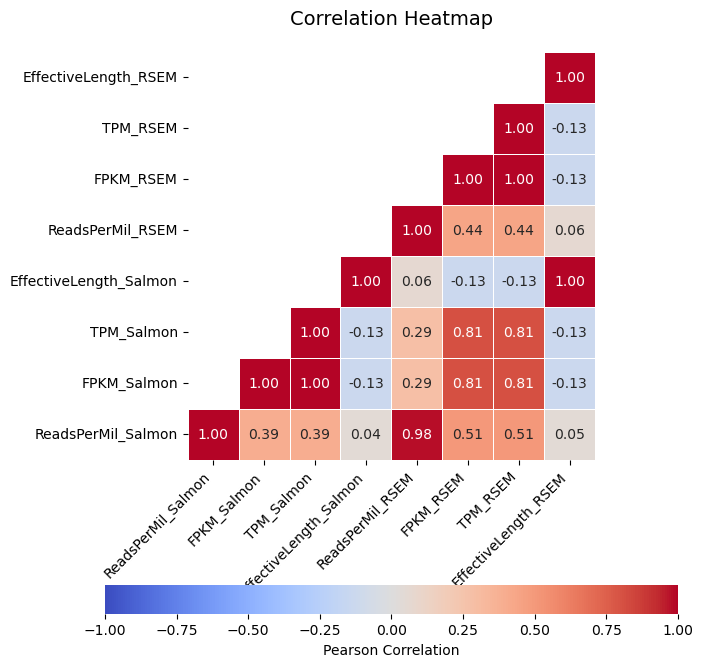

In [11]:
import seaborn as sns

# Reverse the index order
cormat_upper_reversed = cormat_upper.iloc[::-1, :]

# Create figure
plt.figure(figsize=(7, 7))

# Plot heatmap
sns.heatmap(
    cormat_upper_reversed,  # Upper triangular correlation matrix
    cmap="coolwarm",  # Blue-white-red color scheme
    annot=True,  # Display correlation coefficient values
    fmt=".2f",  # Retain two decimal places
    linewidths=0.5,  # Cell borders
    vmin=-1, vmax=1,  # Color range [-1, 1]
    center=0,  # Midpoint of color gradient set to 0
    square=True,  # Ensure square-shaped cells
    cbar_kws={
        "orientation": "horizontal",  # Horizontal color bar
        "label": "Pearson Correlation",  # Color bar label
        "pad": 0.2  # Adjust distance between color bar and heatmap
    }
)

# Adjust axis labels
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout and aesthetics
plt.title("Correlation Heatmap", fontsize=14, pad=20)  # Title
plt.tight_layout()  # Auto-adjust subplots to prevent overlap

# Show figure
plt.show()

**Observations from the Heatmap:**

1. `Effective Length` from RSEM and Salmon are perfectly correlated.
2. However, `Effective Length` has almost no correlation with the other three metrics from both methods.
3. `ReadsPerMil` (normalized read count) from RSEM and Salmon are nearly perfectly correlated.
4. `ReadsPerMil` has low correlation with TPM and FPKM from both methods.
5. TPM and FPKM from RSEM and Salmon are highly correlated (Pearson correlation coefficient = 0.81).

**Additional Observations:**

1. `FPKM` and `TPM` within RSEM are perfectly correlated.
2. `FPKM` and `TPM` within Salmon are also perfectly correlated.

Moreover, almost all correlation coefficients are positive.

## 3 Scatter Plots Between Different Metrics

We generate scatter plots for different metrics to observe the correlation and quantitative differences between them.

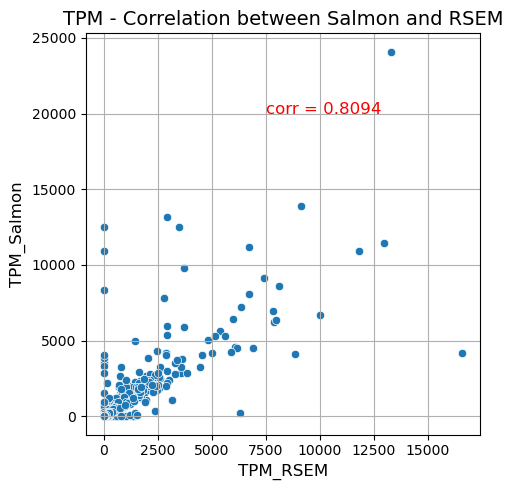

In [12]:
# Extract correlation coefficient
corr1 = cormat.loc["TPM_Salmon", "TPM_RSEM"]

# Plot scatter plot
plt.figure(figsize=(5, 5))
sns.scatterplot(data=dat, x="TPM_RSEM", y="TPM_Salmon")

# Add correlation coefficient annotation
plt.annotate(
    f"corr = {corr1:.4f}",  # Display correlation coefficient with two decimal places
    xy=(7500, 20000),       # Annotation position
    color="red",
    fontsize=12
)

# Add title
plt.title("TPM - Correlation between Salmon and RSEM", fontsize=14)

# Display plot
plt.xlabel("TPM_RSEM", fontsize=12)
plt.ylabel("TPM_Salmon", fontsize=12)
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Prevent overlap
plt.show()

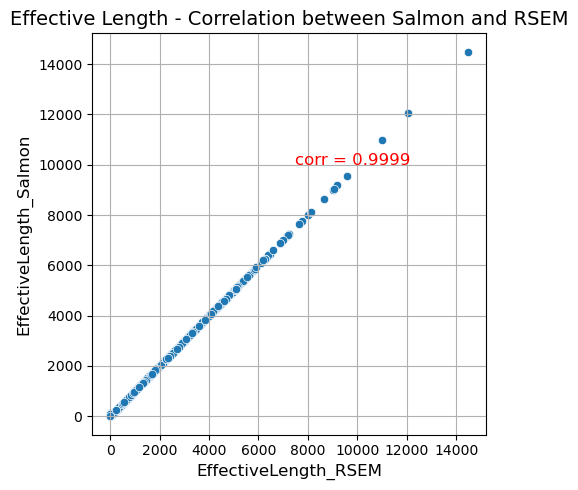

In [13]:
# Extract correlation coefficient
corr2 = cormat.loc["EffectiveLength_Salmon", "EffectiveLength_RSEM"]

# Plot scatter plot
plt.figure(figsize=(5, 5))
sns.scatterplot(data=dat, x="EffectiveLength_RSEM", y="EffectiveLength_Salmon")

# Add correlation coefficient annotation
plt.annotate(
    f"corr = {corr2:.4f}",  # Display correlation coefficient with two decimal places
    xy=(7500, 10000),       # Annotation position
    color="red",
    fontsize=12
)

# Add title
plt.title("Effective Length - Correlation between Salmon and RSEM", fontsize=14)

# Display plot
plt.xlabel("EffectiveLength_RSEM", fontsize=12)
plt.ylabel("EffectiveLength_Salmon", fontsize=12)
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Prevent overlap
plt.show()

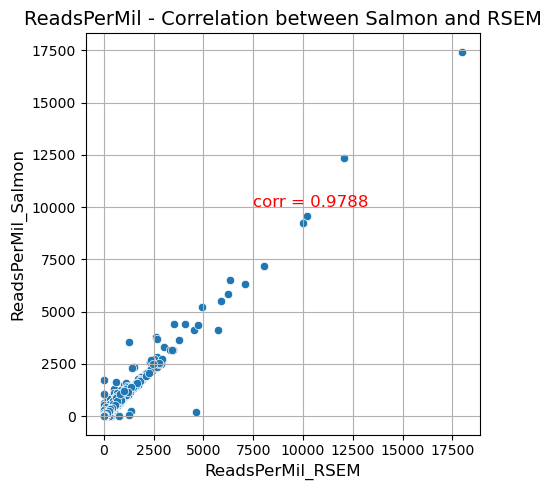

In [14]:
# Extract correlation coefficient
corr3 = cormat.loc["ReadsPerMil_Salmon", "ReadsPerMil_RSEM"]

# Plot scatter plot
plt.figure(figsize=(5, 5))
sns.scatterplot(data=dat, x="ReadsPerMil_RSEM", y="ReadsPerMil_Salmon")

# Add correlation coefficient annotation
plt.annotate(
    f"corr = {corr3:.4f}",  # Display correlation coefficient with two decimal places
    xy=(7500, 10000),       # Annotation position
    color="red",
    fontsize=12
)

# Add title
plt.title("ReadsPerMil - Correlation between Salmon and RSEM", fontsize=14)

# Display plot
plt.xlabel("ReadsPerMil_RSEM", fontsize=12)
plt.ylabel("ReadsPerMil_Salmon", fontsize=12)
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Prevent overlap
plt.show()